### Validate trained policy offline

In [1]:
import torch
import os
import numpy as np
import cv2
import collections
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import sys
sys.path.append('../../hannes-imitation')
sys.path.append('../../hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

# diffusion_policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy
from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import dict_apply

# hannes_imitation imports
from hannes_imitation.dataset.hannes_dataset import HannesImageDataset
from hannes_imitation.dataset.hannes_dataset_hand_wrist_FE import HannesImageDatasetWrist

from hannes_imitation.common import plot_utils
from hannes_imitation.common.data_utils import resize_image

In [2]:
# Load train/validation dataset
zarr_path = '/home/calessi-iit.local/Projects/hannes-imitation/data/training/merged_1_4_7.zarr' # NOTE: IROS 2025
keys = ['image_in_hand', 'ref_move_hand', 'ref_move_wrist_FE', 'ref_move_wrist_PS', 'mes_hand', 'mes_wrist_FE']
val_ratio = 0.2
seed = 72
max_train_episodes = None
horizon = 8 # default 16 # prediction horizon
observation_horizon = 2 # default 2
action_horizon = 4 # default 8
pad_before = observation_horizon - 1
pad_after = action_horizon - 1

# training and validation dataset
#train_dataset = HannesImageDataset(zarr_path, keys, horizon=horizon, pad_before=pad_before, pad_after=pad_after, seed=seed, val_ratio=val_ratio, max_train_episodes=None)
train_dataset = HannesImageDatasetWrist(zarr_path, keys, obs_horizon=observation_horizon, horizon=horizon, pad_before=pad_before, pad_after=pad_after, 
                                        seed=seed, val_ratio=val_ratio, max_train_episodes=None)
validation_dataset = train_dataset.get_validation_dataset()

In [3]:
# get global episode indeces for the training set and validation set
tr_episode_indeces = [i for i, mask in enumerate(train_dataset.train_mask) if mask]
vl_episode_indeces = [i for i, mask in enumerate(validation_dataset.train_mask) if mask]

tr_labels = [train_dataset.labels[i] for i in tr_episode_indeces]
vl_labels = [train_dataset.labels[i] for i in vl_episode_indeces]

In [4]:
# load model
policy_path = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/policy_1_4_7_2025_2_19-21_10_9.pth' # iros2025
checkpoint = torch.load(policy_path)
policy = checkpoint['policy']

In [5]:
# device transfer
device = torch.device('cuda')
_ = policy.to(device).eval()

### Evaluate on episode

In [100]:
from hannes_imitation.scripts.validate_policy import create_observation_dictionaries, evaluate_policy_on_episode, compute_episode_errors_per_horizon

In [ ]:
# choose episode
idx = np.random.choice(tr_episode_indeces)
idx = np.random.choice(vl_episode_indeces)

episode = train_dataset.replay_buffer.get_episode(idx)

In [8]:
results_dicts = []

for i, ep_idx in enumerate(vl_episode_indeces):
    episode = train_dataset.replay_buffer.get_episode(ep_idx)
    action_sequences, actions_gt = evaluate_policy_on_episode(policy, episode, observation_horizon=policy.n_obs_steps) # {'executed', 'predicted'}

    executed_actions = np.array(action_sequences['executed'])
    errors = compute_episode_errors_per_horizon(actions_gt, pred_actions=executed_actions, observation_horizon=policy.n_obs_steps, h=0)

    # append results
    results_dicts.append(vl_labels[i])
    results_dicts[-1]['errors'] = errors

In [138]:
# process results
table_grasp_errors = []
shelf_grasp_errors = []
human_to_hannes_handover_errors = []

for result_dict in results_dicts:
    if result_dict['scenario'] == 'table':
        table_grasp_errors.extend(result_dict['errors'])
    if result_dict['scenario'] == 'shelf':
        shelf_grasp_errors.extend(result_dict['errors'])
    if result_dict['scenario'] == '-':
        human_to_hannes_handover_errors.extend(result_dict['errors'])

table_grasp_errors = np.array(table_grasp_errors)
shelf_grasp_errors = np.array(shelf_grasp_errors)
human_to_hannes_handover_errors = np.array(human_to_hannes_handover_errors)

In [139]:
table_grasp_errors = np.abs(table_grasp_errors)
shelf_grasp_errors = np.abs(shelf_grasp_errors)
human_to_hannes_handover_errors = np.abs(human_to_hannes_handover_errors)

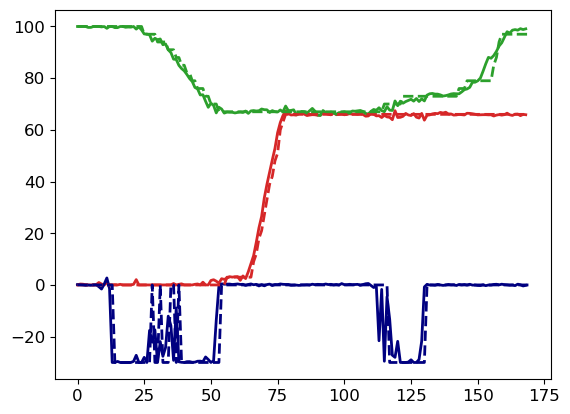

In [ ]:
plt.plot(executed_action_trajectories[:, 0, 0], color='tab:red', linestyle='-', linewidth=2, alpha=1, label="Hand O/C")
plt.plot(executed_action_trajectories[:, 0, 1], color='tab:green', linestyle='-', linewidth=2, alpha=1, label='Wrist F/E')
plt.plot(executed_action_trajectories[:, 0, 2], color='navy', linestyle='-', linewidth=2, alpha=1, label='Wrist P/S')

plt.plot(actions_gt[:, 0], color='tab:red', linestyle='--', linewidth=2, alpha=1, label="Hand O/C")
plt.plot(actions_gt[:, 1], color='tab:green', linestyle='--', linewidth=2, alpha=1, label='Wrist F/E')
plt.plot(actions_gt[:, 2], color='navy', linestyle='--', linewidth=2, alpha=1, label='Wrist P/S')

plt.show()

#### Action error over time

```python
action_error_0 = np.mean(np.abs(actions_gt - action_trajectories[:, 0]), axis=1) # no horizon
action_error_1 = np.mean(np.abs(actions_gt[1:] - action_trajectories[:-1, 1]), axis=1) # horizon 1
action_error_2 = np.mean(np.abs(actions_gt[2:] - action_trajectories[:-2, 2]), axis=1) # horizon 2
```

Idea illustrated below (sample time goes right, prediction horizon goes down): [x means that that index is ignored]

for horizon 0 (i.e. 1 step prediction)
- actions_gt      [a0, a1, a2, a3, ..., aN]
- actions_pred_h0 [a00, a10, a20, a30, ... aN0] 

for horizon 1 (i.e., 2 step prediciton)
- actions_gt      [x, a1, a2, a3, ..., a_N]
- actions_pred_h1 [a01, a11, a21, ..., a_(N-1,1), x] 

In [137]:
action_errors_horizon = {h: None for h in range(action_horizon)}
for h in range(action_horizon):
    a_gt_horizon = actions_gt[h:] # skip the first h actions to get ground truth with horizon h
    if h > 0:
        a_pred_horizon = action_trajectories[:-h, h] # skip last h samples but take the prediction with horizon h starting from the first sample
    else:
        a_pred_horizon = action_trajectories[:, h] # NOTE: this because [:-0] does not work as expected

    # average over action dimension
    action_errors_horizon[h] = np.mean(np.abs(a_gt_horizon - a_pred_horizon), axis=1) # (episode_len, 1)
    #action_errors_horizon[h] = np.abs(a_gt_horizon - a_pred_horizon) # (episode_len, 1)

alphas = np.ones(action_horizon)
alphas[1:] = np.linspace(0.5, 0.1, num=action_horizon-1)

# plot
plt.figure(figsize=(6,3))
plt.plot(action_errors_horizon[h], color='tab:red', linewidth=2, alpha=alphas[0], label='0')

for h in range(1, action_horizon):
    plt.plot(action_errors_horizon[h], color='grey', alpha=alphas[h], label='%d' % h)

plt.xlabel("Control step")
plt.ylabel("Action error")

plt.grid(linewidth=0.5, linestyle='--')
plt.legend(title='Horizon, $T_a$', loc='best', ncols=2)
plt.xlim([50, 100]) # break axis?
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
for i in range(action_horizon):
    print("horizon %d, MAE: %.2f +- %.2f" % (i, action_errors_horizon[i].mean(), action_errors_horizon[i].std()))

### Reference vs predicted actions

In [ ]:
# ONE ACTION
plt.figure(figsize=(6,3))
plt.plot(actions_gt, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')
plt.plot(np.arange(0, episode_len), action_trajectories[:, 0], color='blue', linewidth=2, alpha=0.8, label='Prediction, $0$')

for h in range(1, action_horizon):
    time_axis = np.arange(h, episode_len)
    plt.plot(time_axis, action_trajectories[:-h, h], color='grey', alpha=alphas[h], label='%d' % h)

plt.xlabel("Control step")
plt.ylabel("Action (move_hand)")

plt.grid(linewidth=0.5, linestyle='--')
#plt.xlim([50, 100]) # break axis?

plt.legend(loc='best', ncols=2)
#plt.savefig(fname='../figures/learning_curve.pdf', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../figures/learning_curve.png', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../figures/learning_curve.svg', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
# TWO ACTIONS
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4), sharex=True)

axes[0].plot(actions_gt[:, 0], color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')
axes[0].plot(np.arange(episode_len), action_trajectories[:, 0, 0], color='blue', linewidth=2, alpha=0.8, label='Prediction, $h=0$')
axes[0].set_ylabel("Hand")
axes[0].grid(linewidth=0.5, linestyle='--')
axes[0].legend(loc='best', ncols=1)

axes[1].plot(actions_gt[:, 1], color='red', linestyle='--', linewidth=2, alpha=0.8)
axes[1].plot(np.arange(episode_len), action_trajectories[:, 0, 1], color='blue', linewidth=2, alpha=0.8)
axes[1].set_ylabel("Wrist F/E")
axes[1].grid(linewidth=0.5, linestyle='--')

#for h in range(1, action_horizon):
#    time_axis = np.arange(h, episode_len)
#    plt.plot(time_axis, action_trajectories[:-h, h, 0], color='grey', alpha=alphas[h], label='%d' % h)

plt.xlabel("Control step")
#plt.xlim([50, 100]) # break axis?

#plt.savefig(fname='../figures/learning_curve.pdf', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../figures/learning_curve.png', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../figures/learning_curve.svg', bbox_inches='tight', dpi=600)
plt.show()

### Video (frames + predictions)

In [ ]:
# ONE ACTION
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# images
line_img = ax1.imshow(resize_image(frames[0], 2))
ax1.set_xticks([])
ax1.set_yticks([])

# actions
line_action_gt = ax2.plot(np.arange(0, episode_len), actions_gt, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')[0]
line_action_pred = ax2.plot(np.arange(0, episode_len), action_trajectories[:, 0], color='blue', linewidth=2, alpha=0.8, label='Prediction')[0]

ax2.set_xlabel("Control step")
ax2.set_ylabel("Action (move_hand)")
ax2.grid(linewidth=0.5, linestyle='--')
ax2.legend(loc='upper left', ncols=1)

# Initialize function
def init():
    line_img.set_data([[]])

    line_action_gt.set_data([], [])
    line_action_pred.set_data([], [])
    
    return line_img, line_action_gt, line_action_pred

# Update function
def update(frame):
    line_img.set_data(frames[frame])

    line_action_gt.set_data(np.arange(0, frame), actions_gt[:frame])
    line_action_pred.set_data(np.arange(0, frame), action_trajectories[:frame, 0])

    return line_img, line_action_gt, line_action_pred

# Create animation
ani = FuncAnimation(fig, update, frames=episode_len, init_func=init, blit=False)
ani.save("../figures/hannes_policy_evaluation_offline.mp4", writer="ffmpeg", fps=sampling_frequency, dpi=600)

plt.show()

In [ ]:
# TWO ACTIONS
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))

gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])  # Span all rows in the first column
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)  # Bottom-right

# Create the left plot (spanning both rows), images
line_img = ax1.imshow(resize_image(frames[0], 2))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Eye-in-hand camera view', fontweight="bold")

# Create the top-right plot
line_action_gt_1 = ax2.plot(np.arange(0, episode_len), actions_gt[:, 0], color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')[0]
line_action_pred_1 = ax2.plot(np.arange(0, episode_len), action_trajectories[:, 0, 0], color='blue', linewidth=2, alpha=0.8, label='Prediction')[0]
ax2.set_ylabel("Hand")
ax2.grid(linewidth=0.5, linestyle='--')
ax2.legend(loc='upper left', ncols=1)

# Create the bottom-right plot
line_action_gt_2 = ax3.plot(np.arange(0, episode_len), actions_gt[:, 1], color='red', linestyle='--', linewidth=2, alpha=0.8, label='Reference')[0]
line_action_pred_2 = ax3.plot(np.arange(0, episode_len), action_trajectories[:, 0, 1], color='blue', linewidth=2, alpha=0.8, label='Prediction')[0]
ax3.set_ylabel("Wrist F/E")
ax3.grid(linewidth=0.5, linestyle='--')
ax3.set_xlabel("Control step")

# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Initialize function
def init():
    line_img.set_data([[]])

    line_action_gt_1.set_data([], [])
    line_action_pred_1.set_data([], [])
    
    line_action_gt_2.set_data([], [])
    line_action_pred_2.set_data([], [])

    return line_img, line_action_gt_1, line_action_pred_1, line_action_gt_2, line_action_pred_2

# Update function
def update(frame):
    line_img.set_data(frames[frame])

    line_action_gt_1.set_data(np.arange(0, frame), actions_gt[:frame, 0])
    line_action_pred_1.set_data(np.arange(0, frame), action_trajectories[:frame, 0, 0])

    line_action_gt_2.set_data(np.arange(0, frame), actions_gt[:frame, 1])
    line_action_pred_2.set_data(np.arange(0, frame), action_trajectories[:frame, 0, 1])

    return line_img, line_action_gt_1, line_action_pred_1, line_action_gt_2, line_action_pred_2

# Create animation
ani = FuncAnimation(fig, update, frames=episode_len, init_func=init, blit=False)
ani.save("../figures/hannes_policy_evaluation_hand_wrist_FE_offline.mp4", writer="ffmpeg", fps=sampling_frequency, dpi=600)

#### Extra: Count parameters

In [99]:
# define function
count_parameters = lambda net: np.sum([np.prod(params.shape) for params in net.parameters()])

unet_count = count_parameters(policy.model)
resnet_count = count_parameters(policy.obs_encoder)

print("UNet parameters:", unet_count)
print("ResNet parameters:", resnet_count)

UNet parameters: 965539
ResNet parameters: 11176512
